In [86]:
import os

import numpy as np
from scipy import sparse as ss
import pandas as pd
import polars as pl
# at the time of writing (11/17/2023), h5py 3.9 is needed (cannot use 3.10)
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
raw_dir = "/mnt/c/aws_data/data/10x/visium_cytassist_ffpe_human_colorectal_cancer"
data_dir = "/mnt/c/aws_data/SpatialSplicing/repeat_polyapipe/data/visium_cytassist_ffpe_human_colorectal_cancer"

In [139]:
adata = sc.read_visium(
    raw_dir,
    count_file="CytAssist_11mm_FFPE_Human_Colorectal_Cancer_raw_feature_bc_matrix.h5",
)
adata

/home/whatever60/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/whatever60/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 14336 × 37082
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [ ]:
adata.write_h5ad(f"{data_dir}/ut_out/adata_visium.h5ad")

In [143]:
adata.obsm["spatial"]
adata.uns["spatial"]["CytAssist_11mm_FFPE_Human_Colorectal_Cancer"]["scalefactors"]

{'regist_target_img_scalef': 0.11539349,
 'tissue_hires_scalef': 0.038464498,
 'tissue_lowres_scalef': 0.011539349,
 'fiducial_diameter_fullres': 383.4898215426842,
 'spot_diameter_fullres': 219.13704088153384}

## Quality control

In [52]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

/tmp/ipykernel_99616/1125004840.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
/tmp/ipykernel_99616/1125004840.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=4

<Axes: xlabel='n_genes_by_counts'>

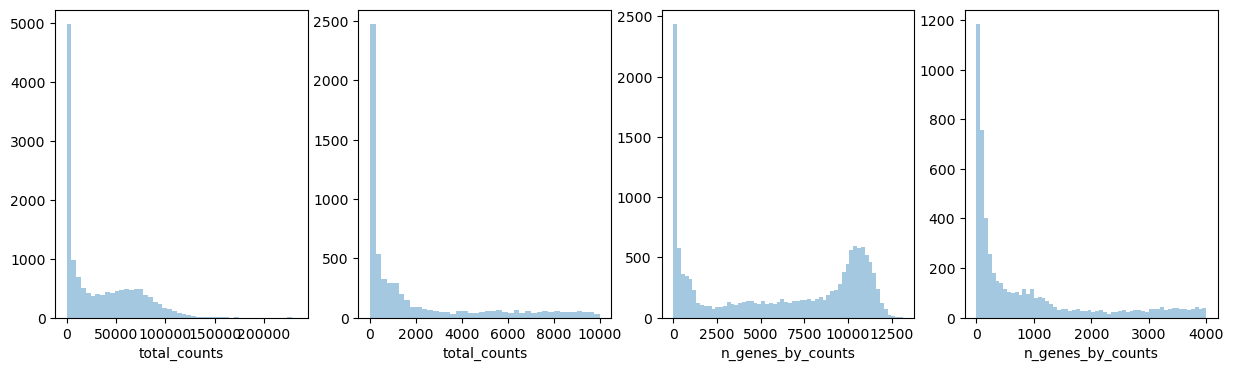

In [53]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [54]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

#cells after MT filter: 3393


/home/whatever60/miniforge3/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/whatever60/miniforge3/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


## Leiden clustering and UMAP

In [55]:
adata

AnnData object with n_obs × n_vars = 3393 × 18940
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

In [56]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

/home/whatever60/miniforge3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/whatever60/miniforge3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


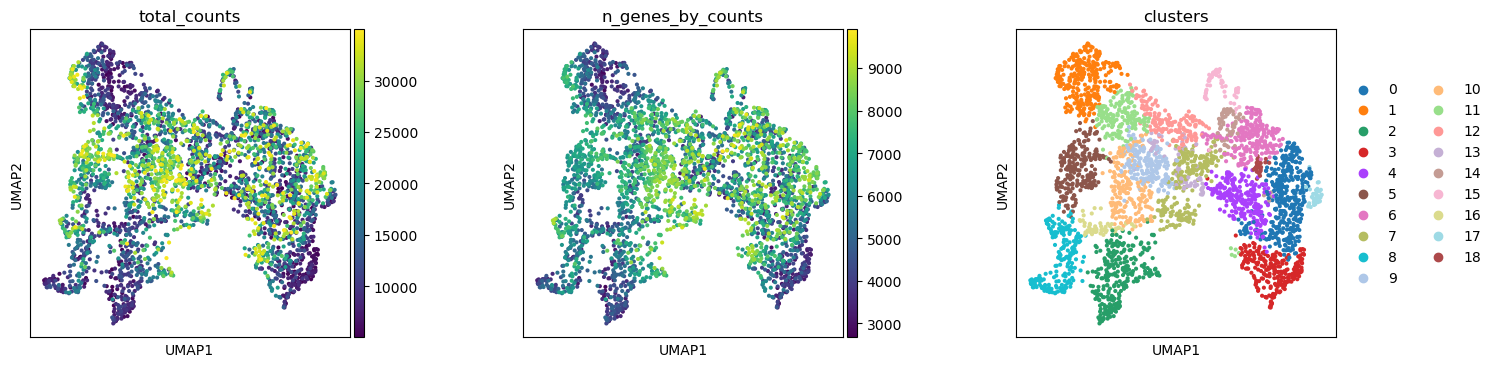

In [57]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

In [58]:
adata.uns["spatial"]["CytAssist_11mm_FFPE_Human_Colorectal_Cancer"]["scalefactors"]

{'regist_target_img_scalef': 0.11539349,
 'tissue_hires_scalef': 0.038464498,
 'tissue_lowres_scalef': 0.011539349,
 'fiducial_diameter_fullres': 383.4898215426842,
 'spot_diameter_fullres': 219.13704088153384}

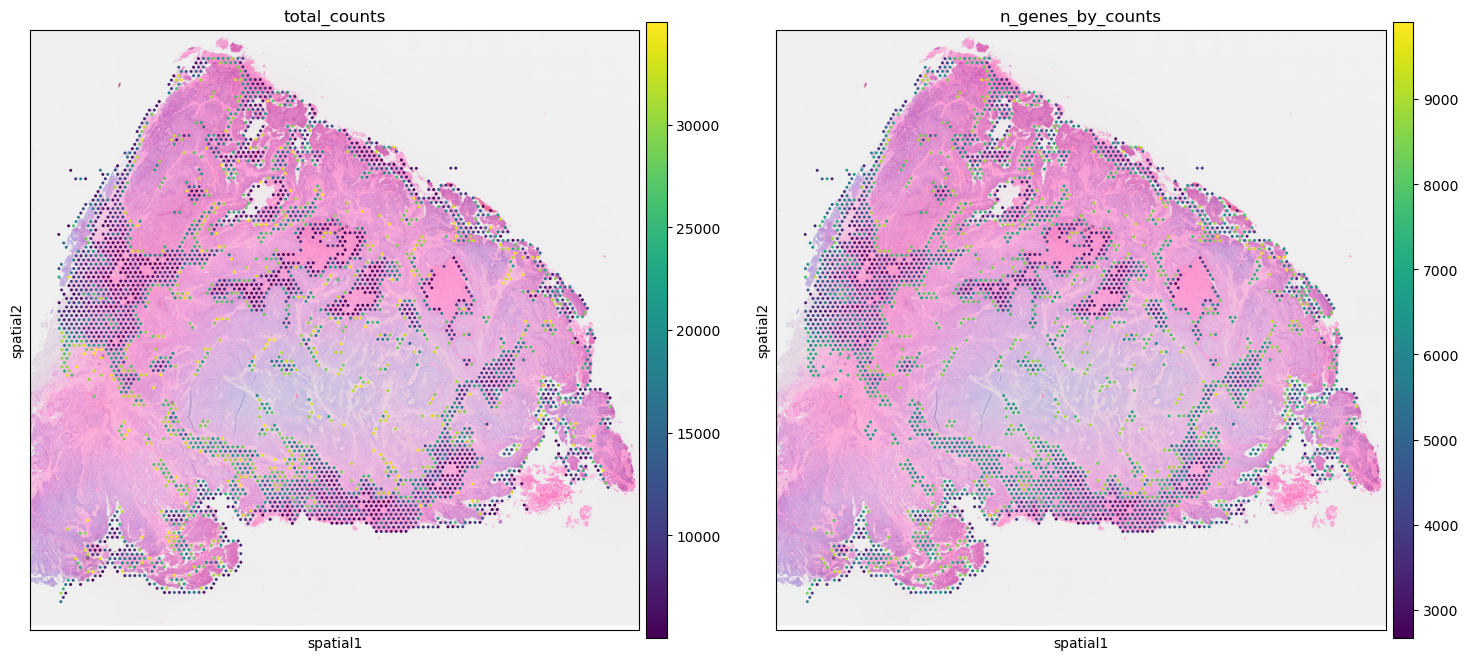

In [59]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

## Allright, let's look at alternative poly-A data

In [169]:
df_pa = pl.read_csv(f"{data_dir}/ut_out/counts.tsv.gz", separator="\t")

In [170]:
df_pa["cell"].unique().shape[0], df_pa["gene"].unique().shape[0]

(13363, 700)

In [173]:
df_pa = df_pa.sort("cell").with_columns(
    gene_id=pl.col("gene").str.split("_").list.first(),
    polya_site=pl.col("gene").str.split("_").list.last(),
    cell_idx=pl.col("cell").cast(pl.Categorical()).to_physical(),
    gene_idx=pl.col("gene").cast(pl.Categorical()).to_physical(),
)
df_num_apa_sites_of_genes = df_pa.unique("gene_idx")["gene_id"].value_counts()
df_num_apa_sites_of_genes.select(pl.col("counts").alias("num_apa_sites"))[
    "num_apa_sites"
].value_counts().sort("num_apa_sites")

num_apa_sites,counts
u32,u32
1,208
2,113
3,80
4,4
5,2


In [174]:
last_data_dir = "/mnt/c/Users/quym/OneDrive - Columbia University Irving Medical Center/thesis/isosde/simulation_data/grid_pikachu"
print(np.load(f"{last_data_dir}/count_nisos_2_beta_0.5_0.2_expre_1_nospv.npy").shape)
print(np.load(f"{last_data_dir}/coords.npy").shape) 

(1000, 2, 1365)
(1365, 2)


In [175]:
df_num_apa_sites_of_genes["counts"].max()

5

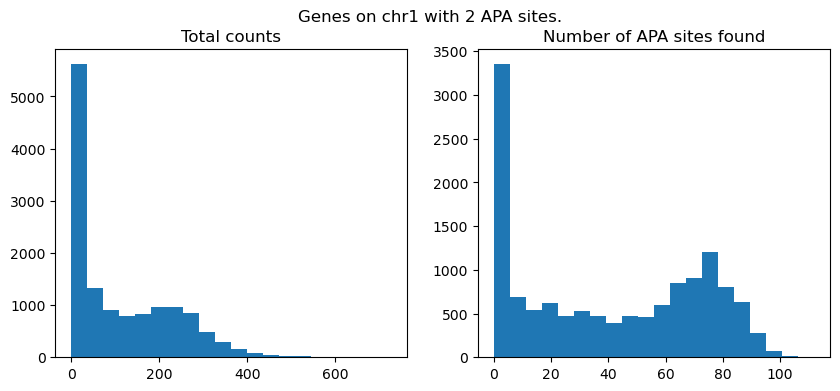

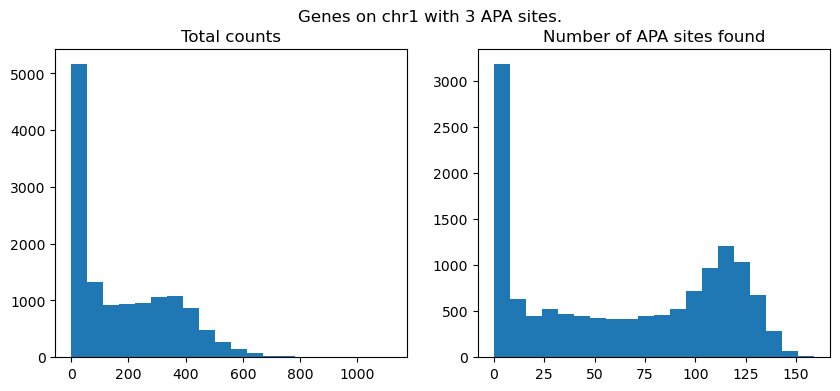

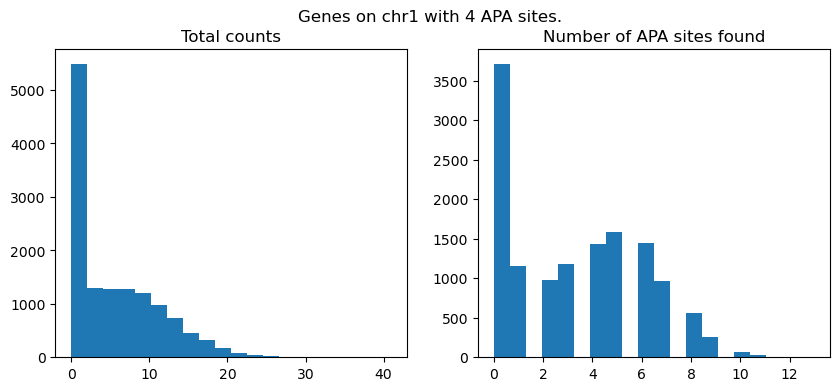

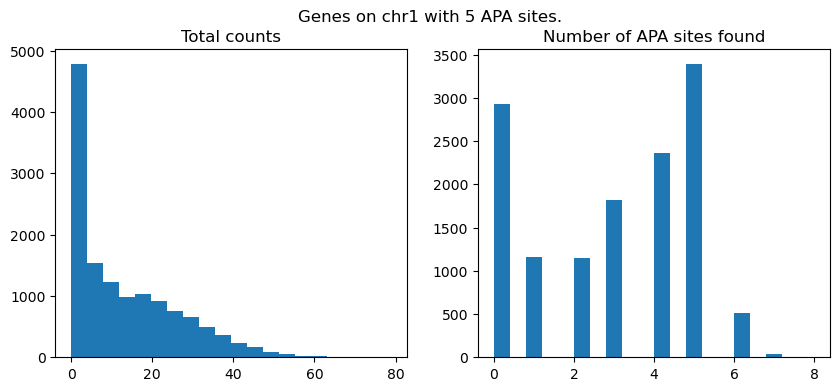

In [177]:
# first column is <gene_id_polya_site>, second column is cell barcode, third column is
# count. Now I want to turn this dataframe into a scipy sparse matrix where the rows are
# genes and columns are cells.
# do this separately for genes with 2 APA sites, 3 APA sites, and so on.
gene_id2num_apa_sites = dict(zip(*df_num_apa_sites_of_genes))
cell_idx2barcode = df_pa.unique("cell_idx")[["cell_idx", "cell"]]
cell_idx2barcode.sort("cell_idx").write_csv(
    f"{data_dir}/ut_out/cells.csv", has_header=False
)
num_cells = cell_idx2barcode.shape[0]

for num_apa_sites in range(2, df_num_apa_sites_of_genes["counts"].max() + 1):
    gene_ids = [g for g, n in gene_id2num_apa_sites.items() if n == num_apa_sites]
    df_temp = (
        df_pa.filter(pl.col("gene_id").is_in(gene_ids))
        .sort("gene_id", "polya_site", "cell_idx")
        .with_columns(gene_idx=pl.col("gene").cast(pl.Categorical()).to_physical())
    )
    mtx = ss.csr_matrix(
        (
            df_temp["count"].to_numpy(),
            (df_temp["gene_idx"].to_numpy(), df_temp["cell_idx"].to_numpy()),
        ),
        shape=(len(gene_ids) * num_apa_sites, num_cells),
    )
    # gene_pas = df_temp.unique("gene").sort("gene_idx")
    # mtxs = []
    # for i in range(num_apa_sites):
    #     df_apa_i = df_temp.filter(
    #         pl.col("gene").is_in(gene_pas["gene"][i::num_apa_sites])
    #     )

    #     mtx = ss.csr_matrix(
    #         (
    #             df_apa_i["count"].to_numpy(),
    #             (df_apa_i["gene_idx"].to_numpy(), df_apa_i["cell_idx"].to_numpy()),
    #         ),
    #         shape=(num_genes, num_cells),
    #     )
    #     mtxs.append(mtx)
    # mtx = ss.vstack(mtxs)

    # save the matrices and metadata
    ss.save_npz(f"{data_dir}/ut_out/mtx_apa_{num_apa_sites}.npz", mtx)
    df_temp.unique("gene_idx")[["gene_idx", "gene"]].sort("gene_idx").write_csv(
        f"{data_dir}/ut_out/genes_apa_{num_apa_sites}.csv", has_header=False
    )

    # do some very basic qc (number of apa sites found and total apa counts)
    # convert to csc matrix for faster column-wise operations
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].hist(mtx.sum(axis=0).A.flatten(), bins=20)
    ax[0].set_title("Total counts")
    ax[1].hist((mtx > 0).sum(axis=0).A.flatten(), bins=20)
    ax[1].set_title("Number of APA sites found")
    fig.suptitle(f"Genes on chr1 with {num_apa_sites} APA sites.")